<a href="https://colab.research.google.com/github/Parth7/ML-for-finance/blob/main/Wavenet_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ^GSPC.csv to ^GSPC.csv
Saving ^IXIC.csv to ^IXIC.csv
Saving AAPL.csv to AAPL.csv
Saving MSFT.csv to MSFT.csv


In [3]:
import io
aapl_raw = pd.read_csv(io.StringIO(uploaded['AAPL.csv'].decode('utf-8')))
msft_raw = pd.read_csv(io.StringIO(uploaded['MSFT.csv'].decode('utf-8')))
nsdq_raw = pd.read_csv(io.StringIO(uploaded['^IXIC.csv'].decode('utf-8')))
sp500_raw = pd.read_csv(io.StringIO(uploaded['^GSPC.csv'].decode('utf-8')))

In [4]:
aapl_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4865 entries, 0 to 4864
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4865 non-null   object 
 1   Open       4865 non-null   float64
 2   High       4865 non-null   float64
 3   Low        4865 non-null   float64
 4   Close      4865 non-null   float64
 5   Adj Close  4865 non-null   float64
 6   Volume     4865 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 266.2+ KB


In [5]:
aapl_raw.index = pd.to_datetime(aapl_raw.Date).dt.date
msft_raw.index = pd.to_datetime(msft_raw.Date).dt.date
sp500_raw.index = pd.to_datetime(sp500_raw.Date).dt.date
nsdq_raw.index = pd.to_datetime(nsdq_raw.Date).dt.date

In [6]:
aapl_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-01-03,2000-01-03,3.745536,4.017857,3.631696,3.997768,2.665724,133949200
2000-01-04,2000-01-04,3.866071,3.950893,3.613839,3.660714,2.440975,128094400
2000-01-05,2000-01-05,3.705357,3.948661,3.678571,3.714286,2.476697,194580400
2000-01-06,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.262367,191993200
2000-01-07,2000-01-07,3.446429,3.607143,3.410714,3.553571,2.369532,115183600


In [7]:
aapl_raw['aAC'] = aapl_raw['Adj Close']
msft_raw['mAC'] = msft_raw['Adj Close']
sp500_raw['sAC'] = sp500_raw['Adj Close']
nsdq_raw['nAC'] = nsdq_raw['Adj Close']

In [8]:
aapl_raw['aV'] = aapl_raw['Volume']
msft_raw['mV'] = msft_raw['Volume']
sp500_raw['sV'] = sp500_raw['Volume']
nsdq_raw['nV'] = nsdq_raw['Volume']

In [9]:
aapl = aapl_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
msft = msft_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
sp500 = sp500_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
nsdq = nsdq_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
aapl.head()

,aAC,aV
Date,,
2000-01-03,2.665724,133949200
2000-01-04,2.440975,128094400
2000-01-05,2.476697,194580400
2000-01-06,2.262367,191993200
2000-01-07,2.369532,115183600


In [10]:
aapl.describe().round(2)

,aAC,aV
count,4865.00,4.865000e+03
mean,47.39,1.179476e+08
std,57.15,9.905649e+07
min,0.62,9.835000e+06
25%,3.01,5.076120e+07
50%,17.91,9.108610e+07
75%,86.43,1.539104e+08
max,230.28,1.855410e+09


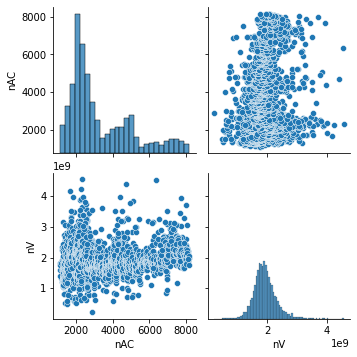

In [11]:
sns.pairplot(nsdq);

In [12]:
df = pd.concat([sp500, nsdq, msft, aapl], axis=1)
df.head()

,sAC,sV,nAC,nV,mAC,mV,aAC,aV
Date,,,,,,,,
2000-01-03,1455.219971,931800000,4131.149902,1510070000,42.115314,53228400,2.665724,133949200
2000-01-04,1399.420044,1009000000,3901.689941,1511840000,40.692646,54119000,2.440975,128094400
2000-01-05,1402.109985,1085500000,3877.540039,1735670000,41.121727,64059600,2.476697,194580400
2000-01-06,1403.449951,1092300000,3727.129883,1598320000,39.744217,54976600,2.262367,191993200
2000-01-07,1441.469971,1225200000,3882.620117,1634930000,40.263588,62013600,2.369532,115183600


In [13]:
from fbprophet import Prophet

# pull only close price and set up dataframe for prophet
aapl_fb = aapl
aapl_fb['ds'] = aapl_fb.index
aapl_fb = aapl_fb.rename(columns={'aAC': 'y'})

In [14]:
aapl_fb.head()

,y,aV,ds
Date,,,
2000-01-03,2.665724,133949200,2000-01-03
2000-01-04,2.440975,128094400,2000-01-04
2000-01-05,2.476697,194580400,2000-01-05
2000-01-06,2.262367,191993200,2000-01-06
2000-01-07,2.369532,115183600,2000-01-07


In [15]:
# fit model without final thirty periods
fbm = Prophet(weekly_seasonality='auto', daily_seasonality=False, seasonality_mode='additive')

fbm.fit(aapl_fb.iloc[:-30,:]);

# create future dataset
future = fbm.make_future_dataframe(periods=30, freq='D')
future.tail()

,ds
4860,2019-04-17
4861,2019-04-18
4862,2019-04-19
4863,2019-04-20
4864,2019-04-21


In [16]:
aapl_fb.iloc[-30,:]
forecast = fbm.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
4860,2019-04-17,193.258873,181.109063,205.316772
4861,2019-04-18,193.290025,180.622398,205.821975
4862,2019-04-19,193.288413,181.652264,204.771614
4863,2019-04-20,193.520526,181.388970,205.570293
4864,2019-04-21,193.605109,181.077873,205.227321


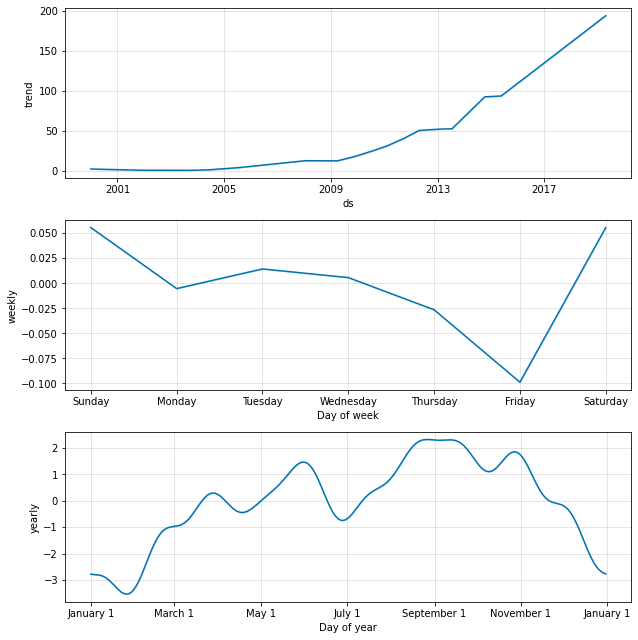

In [17]:
fbm.plot_components(forecast);

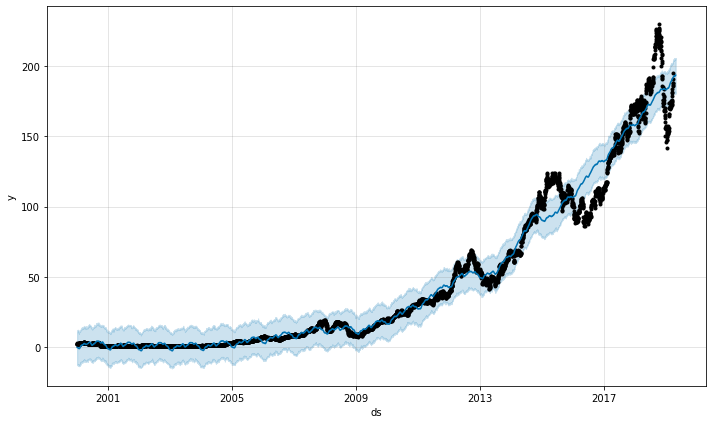

In [18]:
pred_plot = fbm.plot(forecast)

In [19]:
# calculate MAE

diffs = np.absolute(aapl_fb.y[-30:].values - forecast.yhat[-30:].values)

diffs.mean() # this is our metric for comparison

8.223783622551272

In [20]:
df = df.T

In [21]:
from datetime import timedelta

data_start_date = df.columns[1]
data_end_date = df.columns[-1]

pred_steps = 100
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [22]:

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [23]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2000-01-04 00:00:00 - 2018-10-18 00:00:00
Train prediction: 2018-10-19 00:00:00 - 2019-01-26 00:00:00 

Val encoding: 2000-04-13 00:00:00 - 2019-01-26 00:00:00
Val prediction: 2019-01-27 00:00:00 - 2019-05-06 00:00:00

Encoding interval: 6863
Prediction interval: 100


In [24]:

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log(series_array)
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log(series_array)
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [25]:

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

In [26]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(7)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract training target at end
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':66})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [27]:
first_n_samples = 8
batch_size = 2**10
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

In [28]:
model.compile(Adam(), loss='mean_absolute_error')

history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.20)

Epoch 1/100
1/1 [==============================] - 34s 34s/step - loss: 0.6621 - val_loss: 1.6298
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.6370 - val_loss: 1.6074
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.6194 - val_loss: 1.5879
Epoch 4/100
1/1 [==============================] - 1s 970ms/step - loss: 0.5993 - val_loss: 1.5670
Epoch 5/100
1/1 [==============================] - 1s 949ms/step - loss: 0.5711 - val_loss: 1.5438
Epoch 6/100
1/1 [==============================] - 1s 964ms/step - loss: 0.5430 - val_loss: 1.5172
Epoch 7/100
1/1 [==============================] - 1s 950ms/step - loss: 0.5077 - val_loss: 1.4832
Epoch 8/100
1/1 [==============================] - 1s 947ms/step - loss: 0.4700 - val_loss: 1.4420
Epoch 9/100
1/1 [==============================] - 1s 979ms/step - loss: 0.4165 - val_loss: 1.3904
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 0.3761 - val_loss: 1.3255
Epoch 11/100
1/1 [=

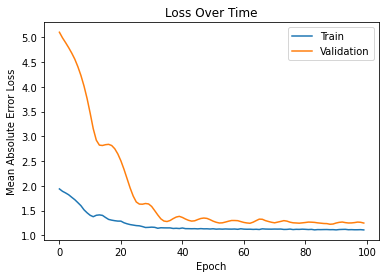

In [29]:
plt.plot(np.exp(history.history['loss']))
plt.plot(np.exp(history.history['val_loss']))

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Validation']);

In [30]:

def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [31]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [32]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)  
    target_series = decoder_target_data[sample_ind,:,:].reshape(-1,1)
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    #plt.figure(figsize=(10,6))   

    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps-31),target_series,color='green')
    plt.plot(range(x_encode,x_encode+pred_steps-31),pred_series[:69],color='red',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

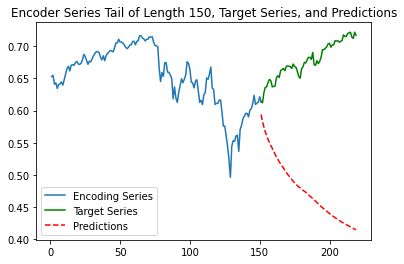

In [33]:
# sp500 prediction
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=0, enc_tail_len=150)

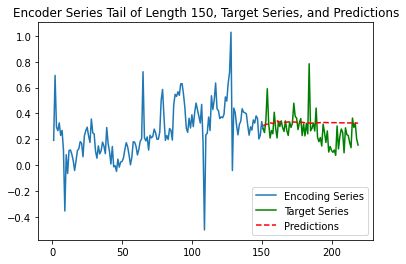

In [34]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1, enc_tail_len=150)

In [35]:
df.index

Index(['sAC', 'sV', 'nAC', 'nV', 'mAC', 'mV', 'aAC', 'aV'], dtype='object')

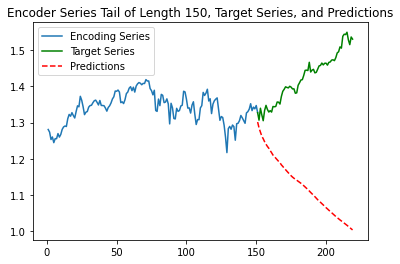

In [36]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=4, enc_tail_len=150)

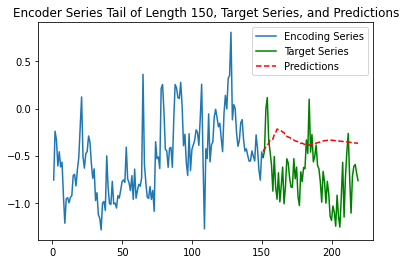

In [37]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=5, enc_tail_len=150)